# Chargement des array si existants

In [1]:
import numpy as np

X_train = np.load('arrays/X_train.npy')
y_train = np.load('arrays/y_train.npy')
X_test = np.load('arrays/X_test.npy')
y_test = np.load('arrays/y_test.npy')

# Réduction de la dimension par ACP

In [2]:
X_train[1].shape

(64, 64, 3)

In [3]:
X_train_r = X_train.reshape(X_train.shape[0],-1)
X_test_r = X_test.reshape(X_test.shape[0],-1)
print('X_train',X_train_r.shape)
print('X_test',X_test_r.shape)

X_train (39987, 12288)
X_test (21532, 12288)


In [4]:
%%time
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_r[:len(X_train):10])#on en prend 1/10 pour éviter d'avoir une seule classe si les données étaient triées parr classes...
cumsum = np.cumsum(pca.explained_variance_ratio_)
nb_dim = np.argmax(cumsum >= 0.95) + 1
print("Nombre de composants expliquant 95% de la variance :", nb_dim)

Nombre de composants expliquant 95% de la variance : 708
CPU times: user 6min 42s, sys: 53.8 s, total: 7min 35s
Wall time: 1min 2s


In [5]:
%%time
pca = PCA(n_components=nb_dim)
X_train_pca = pca.fit_transform(X_train_r)
X_test_pca = pca.transform(X_test_r)

In [6]:
print('X_train',X_train_pca.shape)
print('X_test',X_test_pca.shape)

X_train (39987, 708)
X_test (21532, 708)


# Création d'un y de dimension 1 : juste les classes

In [7]:
y_train_cl = np.argmax(y_train, axis=1)
y_test_cl = np.argmax(y_test, axis=1)
print('y_train',y_train_cl.shape)
print('y_test',y_test_cl.shape)

y_train (39987,)
y_test (21532,)


# Modèle XGBoost sur données réduites

In [8]:
from xgboost import XGBClassifier
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

/home/elka/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [9]:
%%time
xgb.fit(X_train_pca, y_train_cl)

CPU times: user 24min, sys: 2.53 s, total: 24min 3s
Wall time: 3min 10s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

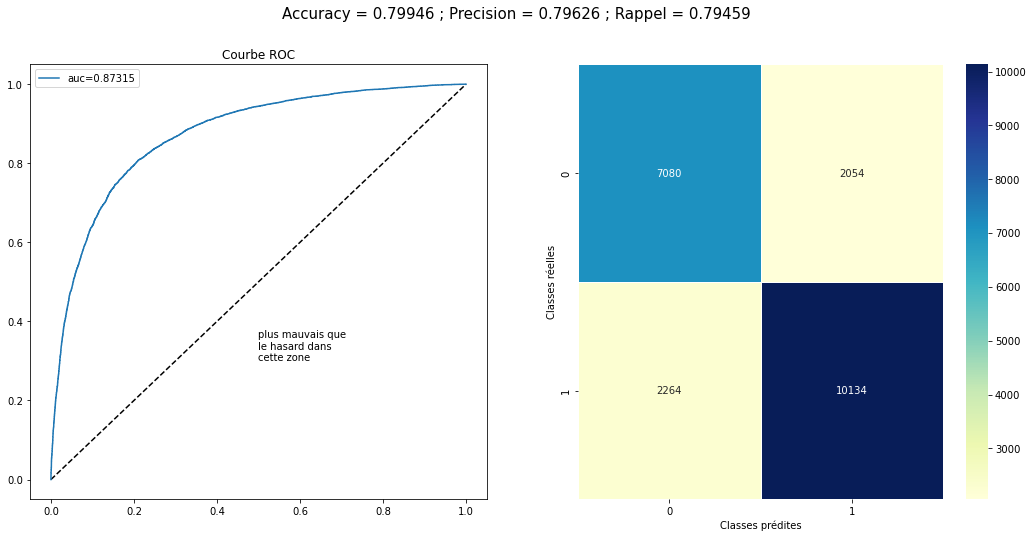

In [10]:
# évaluation du modèle XGBoost
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support

y_pred = xgb.predict(X_test_pca) 
proba_1 = xgb.predict_proba(X_test_pca)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test_cl, proba_1, pos_label=1, drop_intermediate=False)
aucf = auc(fpr, tpr)
cm = confusion_matrix(y_pred, y_test_cl)
accuracy = accuracy_score(y_pred, y_test_cl)
precision, rappel = precision_recall_fscore_support(y_test_cl, y_pred, pos_label=1, average='macro')[0:2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
ax1.plot([0, 1], [0, 1], 'k--')
ax1.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax1.set_title('Courbe ROC')
ax1.text(0.5, 0.3, "plus mauvais que\nle hasard dans\ncette zone")
ax1.legend()

sns.heatmap(cm, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu", ax=ax2)
ax2.set_xlabel('Classes prédites')
ax2.set_ylabel('Classes réelles')

plt.suptitle("Accuracy = {:0.5} ; Precision = {:0.5} ; Rappel = {:0.5}".format(accuracy,precision,rappel), fontsize = 15 )
plt.show()